In [5]:
import pandas as pd
import numpy as np
import string
import nltk
import os
from datetime import datetime
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import ngrams
from nltk.collocations import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import math
import csv
import re
import glob
import os
import spacy
!pip install nlp
import nlp
class Journal2:
    def __init__(self):
        pass

# IMPORT DATA
    def importData(self):
      # import data from csv file
      # return the dataframe of imported dataset
        wiki=pd.read_csv('wiki50_distilled.csv')
        wiki.drop('Column4',axis=1,inplace=True)
        wiki.drop(wiki[wiki['Column1']=='-DOCSTART-'].index,inplace=True,axis=0)
        wiki=wiki.iloc[1:]
        wiki=wiki.append({'Column1':np.nan,'Column2':np.nan,'Column3':np.nan},ignore_index=True)
        return wiki

# DATA PREPROCESSING
    def combineRespectiveSentences(self,wiki):
        # parameter train=dataframe of imported data
        # function putting each token back to their own sentences
        # output tarr=lists of all sentences in dataframe, id=sentence id
          temp=''
          tarr=[]
          tinarr=[]
          for x in range(len(wiki)):
              if wiki['Column1'].iloc[x] is np.nan:
                  temp=temp[:-1]
                  temp=temp.replace(' O O ','')
                  temp=temp.replace(' O ',' ')
                  tinarr.append(temp)
                  tarr.append(tinarr)
                  tinarr=[]
                  temp=''
              else:
                  temp=temp+str(wiki['Column1'].iloc[x])+" "
          # to remove unnecessary words labelling mwe such as 'B-NE_xxx', 'O-NE_xxx'
          for x in tarr:
              for y in x[0].split():
                  if y[:2] == 'B-' or y[:2] == 'O-':
                      x[0]=x[0].replace(y,'')
                  x[0]=x[0].replace('  ',' ')
              # to remove punctuations
              for y in x[0]:
                  if y in string.punctuation:
                      x[0]=x[0].replace(y,'')
          return tarr

    def combineAllSentences(self,tarr):
        # parameter train=dataframe of imported data
        # function combining every tokens in the list to become one sentences
        # output a long sentence combining all words in datasets
        text=''
        for x in tarr:
            text+=str(x[0])+' '
        text=text.lower()
        # text=text.replace('o o ','')
        # text=text.replace(' o ',' ')
        text=text.replace('  ',' ')
        return text

    def extractDatasetMWE(self,wiki):
      # parameters wiki= datasets from journal
      # to extract all the multiword expressions annotated in the journal
      # output return list of multiword expressions exists in the journal datasets
        mwe=[]
        word=''
        for x in range(len(wiki)):
            if wiki['Column2'].iloc[x] is not np.nan:
                if wiki['Column2'].iloc[x][:1]=='B':
                    word+=wiki['Column1'].iloc[x]+' '
                    if wiki['Column2'].iloc[x+1] is not np.nan:
                        if wiki['Column2'].iloc[x+1][:1] != 'I':
                            word=''
                    else:
                        word=''
                elif wiki['Column2'].iloc[x][:1]=='I' and word != '':
                    # if wiki['Column1'].iloc[x] == "\'s":
                    #     word=word[:-1]+wiki['Column1'].iloc[x]+' '
                    # else:
                    word+=wiki['Column1'].iloc[x]+' '
                    if wiki['Column2'].iloc[x+1] is not np.nan:
                        if wiki['Column2'].iloc[x+1][:1]!='I':
                            if word[:-1] not in mwe:
                                mwe.append(word[:-1])
                                word=''
                            else:
                                word=''
                    else:
                        if word[:-1] not in mwe:
                            mwe.append(word[:-1])
                            word=''
                        else:
                            word=''
            else:
                word=''
        mwe=np.array(mwe)
        mwe=pd.DataFrame(mwe,columns=['words'])
        y=[]
        # drop mwe with more than 4 grams, less than 2 grams and remove punctuations
        for x in range(len(mwe)):
            if len(mwe['words'].iloc[x].split()) > 4 or len(mwe['words'].iloc[x].split()) < 2:
                y.append(x)
            else:
                for z in mwe['words'].iloc[x]:
                    if z in string.punctuation:
                        mwe['words'].iloc[x]=mwe['words'].iloc[x].replace(z,'')
                    mwe['words'].iloc[x]=mwe['words'].iloc[x].replace('  ',' ')
        mwe.drop(y,inplace=True)
        mwe.reset_index(inplace=True)
        mwe.drop('index',axis=1,inplace=True)
        mwe['pos']=''
        # perform POS tagging on the mwe
        nlp = spacy.load("en_core_web_sm")
        for x in range(len(mwe)):
            # temp=nltk.word_tokenize(mwe['words'].iloc[x])
            temp=nlp(mwe['words'].iloc[x])
            temp2=''
            for y in temp:
                # temp2+=pos_tag([y])[0][1]+' '
                temp2+=y.tag_
            temp2=temp2[:-1]
            mwe['pos'].iloc[x]=temp2
        # drop duplicated mwe
        mwe.drop_duplicates(inplace=True)
        mwe.reset_index(inplace=True)
        mwe.drop('index',axis=1,inplace=True)
        return mwe

    def generatePosTag(self,tarr):
        # input parameters= arrays of each sentences in datasets
        # construct dataframe with tokens and pos tag of words in the sentence
        # output return constructed dataframe
        nlp = spacy.load("en_core_web_sm")
        word2pos=pd.DataFrame(columns=['word','pos'])
        for x in tarr:
            # y=nltk.word_tokenize(str(x[0]))
            y=nlp(str(x[0]))
            for z in y:
                # word2pos=word2pos.append({'word':z,'pos':pos_tag([z])[0][1]},ignore_index=True)
                word2pos=word2pos.append({'word':z,'pos':z.tag_},ignore_index=True)
            word2pos=word2pos.append({'word':np.nan,'pos':np.nan},ignore_index=True)
        return word2pos

    def listPotentialMWE(self,word2pos):
        # input parameters= constructed dataframe consisting all tokens with their pos tag in dataset
        # list down potential mwe 
        # output return new dataframe of potential mwe
        potMwe=[]
        for x in range(len(word2pos)):
            temp=''
            if word2pos['pos'].iloc[x]=='NN' or word2pos['pos'].iloc[x]=='NNS' or word2pos['pos'].iloc[x]=='NNP' or word2pos['pos'].iloc[x]=='NNPS':
                temp+=str(word2pos['word'].iloc[x])+' '
                if word2pos['pos'].iloc[x+1]=='NN' or word2pos['pos'].iloc[x+1]=='NNS' or word2pos['pos'].iloc[x+1]=='NNP' or word2pos['pos'].iloc[x+1]=='NNPS':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    potMwe.append(temp[:-1])
                    if word2pos['pos'].iloc[x+2]=='NN' or word2pos['pos'].iloc[x+2]=='NNS' or word2pos['pos'].iloc[x+2]=='NNP' or word2pos['pos'].iloc[x+2]=='NNPS':
                        temp+=str(word2pos['word'].iloc[x+2])+' '
                        potMwe.append(temp[:-1])
                        if word2pos['pos'].iloc[x+3]=='NN' or word2pos['pos'].iloc[x+3]=='NNS' or word2pos['pos'].iloc[x+3]=='NNP' or word2pos['pos'].iloc[x+3]=='NNPS':
                            temp+=str(word2pos['word'].iloc[x+3])
                            potMwe.append(temp)
                        else:
                            potMwe.append(temp[:-1])
                elif word2pos['pos'].iloc[x+1]=='IN':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='DT':
                        temp+=str(word2pos['word'].iloc[x+2])+' '
                        if word2pos['pos'].iloc[x+3]=='NN' or word2pos['pos'].iloc[x+3]=='NNS' or word2pos['pos'].iloc[x+3]=='NNP' or word2pos['pos'].iloc[x+3]=='NNPS':
                            temp+=str(word2pos['word'].iloc[x+3])
                            potMwe.append(temp)
                    elif word2pos['pos'].iloc[x+2]=='NN' or word2pos['pos'].iloc[x+2]=='NNS' or word2pos['pos'].iloc[x+2]=='NNP' or word2pos['pos'].iloc[x+2]=='NNPS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='POS':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='NN' or word2pos['pos'].iloc[x+2]=='NNS' or word2pos['pos'].iloc[x+2]=='NNP' or word2pos['pos'].iloc[x+2]=='NNPS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='IN':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='JJ' or word2pos['pos'].iloc[x+2]=='JJR' or word2pos['pos'].iloc[x+2]=='JJS':
                        temp+=str(word2pos['word'].iloc[x+2])+' '
                        if word2pos['pos'].iloc[x+3]=='NN' or word2pos['pos'].iloc[x+3]=='NNS' or word2pos['pos'].iloc[x+3]=='NNP' or word2pos['pos'].iloc[x+3]=='NNPS':
                            temp+=str(word2pos['word'].iloc[x+3])
                            potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='CC':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='NN' or word2pos['pos'].iloc[x+2]=='NNS' or word2pos['pos'].iloc[x+2]=='NNP' or word2pos['pos'].iloc[x+2]=='NNPS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
            elif word2pos['pos'].iloc[x]=='JJ' or word2pos['pos'].iloc[x]=='JJR' or word2pos['pos'].iloc[x]=='JJS':
                temp+=str(word2pos['word'].iloc[x])+' '
                if word2pos['pos'].iloc[x+1]=='NN' or word2pos['pos'].iloc[x+1]=='NNS' or word2pos['pos'].iloc[x+1]=='NNP' or word2pos['pos'].iloc[x+1]=='NNPS':
                    temp+=str(word2pos['word'].iloc[x+1])
                    potMwe.append(temp)
            elif word2pos['pos'].iloc[x]=='IN':
                temp+=str(str(word2pos['word'].iloc[x])+' ')
                if word2pos['pos'].iloc[x+1]=='NN' or word2pos['pos'].iloc[x+1]=='NNS' or word2pos['pos'].iloc[x+1]=='NNP' or word2pos['pos'].iloc[x+1]=='NNPS':
                    temp+=str(word2pos['word'].iloc[x+1])
                    potMwe.append(temp)
            elif word2pos['pos'].iloc[x]=='VB':
                temp+=str(word2pos['word'].iloc[x])+' '
                if word2pos['pos'].iloc[x+1]=='IN':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    potMwe.append(temp[:-1])
                    if word2pos['pos'].iloc[x+2]=='RB' or word2pos['pos'].iloc[x+2]=='RBR' or word2pos['pos'].iloc[x+2]=='RBS' or word2pos['pos'].iloc[x+2]=='IN':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
            elif word2pos['pos'].iloc[x]=='VB':
                temp+=str(word2pos['word'].iloc[x]+' ')
                if word2pos['pos'].iloc[x+1]=='RB' or word2pos['pos'].iloc[x+1]=='RBR' or word2pos['pos'].iloc[x+1]=='RBS':
                    temp+=str(word2pos['word'].iloc[x+1]+' ')
                    potMwe.append(temp[:-1])
                    if word2pos['pos'].iloc[x+2]=='RB' or word2pos['pos'].iloc[x+2]=='IN' or word2pos['pos'].iloc[x+2]=='RBR' or word2pos['pos'].iloc[x+2]=='RBS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
            elif word2pos['pos'].iloc[x]=='VB' or word2pos['pos'].iloc[x]=='VBD' or word2pos['pos'].iloc[x]=='VBG' or word2pos['pos'].iloc[x]=='VBN' or word2pos['pos'].iloc[x]=='VBP' or word2pos['pos'].iloc[x]=='VBZ':
                temp+=str(word2pos['word'].iloc[x])+' '
                if word2pos['pos'].iloc[x+1]=='TO':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='VB' or word2pos['pos'].iloc[x+2]=='VBD' or word2pos['pos'].iloc[x+2]=='VBG' or word2pos['pos'].iloc[x+2]=='VBN' or word2pos['pos'].iloc[x+2]=='VBP' or word2pos['pos'].iloc[x+2]=='VBZ':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='JJ' or word2pos['pos'].iloc[x++1]=='JJR' or word2pos['pos'].iloc[x+1]=='JJS':
                    temp+=str(word2pos['word'].iloc[x+1])
                    potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='IN' or word2pos['pos'].iloc[x+1]=='DT' or word2pos['pos'].iloc[x+1]=='PRP$':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='NN' or word2pos['pos'].iloc[x+2]=='NNS' or word2pos['pos'].iloc[x+2]=='NNP' or word2pos['pos'].iloc[x+2]=='NNPS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='RP':
                    temp+=str(word2pos['pos'].iloc[x+1])
                    potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='DT':
                    temp+=str(word2pos['word'].iloc[x+1])
                    if word2pos['pos'].iloc[x+2]=='JJ' or word2pos['pos'].iloc[x+2]=='JJR' or word2pos['pos'].iloc[x+2]=='JJS':
                        temp+=str(word2pos['word'].iloc[x+2]+' ')
                        if word2pos['pos'].iloc[x+3]=='NN' or word2pos['pos'].iloc[x+3]=='NNS' or word2pos['pos'].iloc[x+3]=='NNP' or word2pos['pos'].iloc[x+3]=='NNPS':
                            temp+=str(word2pos['word'].iloc[x+3])
                            potMwe.append(temp)
                elif word2pos['pos'].iloc[x+1]=='RB' or word2pos['pos'].iloc[x+1]=='RBR' or word2pos['pos'].iloc[x+1]=='RBS':
                    temp+=str(word2pos['word'].iloc[x+1])+' '
                    if word2pos['pos'].iloc[x+2]=='JJ' or word2pos['pos'].iloc[x+2]=='JJR' or word2pos['pos'].iloc[x+2]=='JJS':
                        temp+=str(word2pos['word'].iloc[x+2])
                        potMwe.append(temp)
        potMwe=pd.DataFrame(potMwe,columns=['words'])
        potMwe.drop_duplicates(inplace=True)
        potMwe.reset_index(inplace=True)
        potMwe.drop('index',axis=1,inplace=True)
        return potMwe
    # def listPotentialMWE(tarr):
    #     potMwe=[]
    #     for x in tarr:
    #         bi=ngrams(x[0].split(),2)
    #         for y in bi:
    #             potMwe.append(y[0]+' '+y[1])
    #         tri=ngrams(x[0].split(),3)
    #         for y in tri:
    #             potMwe.append(y[0]+' '+y[1]+' '+y[2])
    #         quad=ngrams(x[0].split(),4)
    #         for y in quad:
    #             potMwe.append(y[0]+' '+y[1]+' '+y[2]+' '+y[3])    
    #     potMwe=pd.DataFrame(potMwe,columns=['words'])
    #     potMwe.drop_duplicates(inplace=True)
    #     potMwe.reset_index(inplace=True)
    #     potMwe.drop('index',axis=1,inplace=True)
    #     return potMwe

    def verifyIfMwe(self,potMwe,mwe):
        # input parameters: potMwe=dataframe of possible potential mwe, mwe=dataframe of mwe extracted from datasets
        # check if each row in potmwe is actually mwe or not, if yes, mwe=1, else mwe=0
        # output return dataframe potmwe with label of mwe
        potMwe['p1v1']=0
        potMwe['p2v1']=0
        potMwe['p1v2']=0
        potMwe['p2v2']=0
        potMwe['p1v3']=0
        potMwe['p2v3']=0
        potMwe['totalCount']=0
        potMwe['pmi1']=0
        potMwe['pmi2']=0
        potMwe['pmi3']=0
        potMwe['chi1']=0
        potMwe['chi2']=0
        potMwe['chi3']=0
        potMwe['logL1']=0
        potMwe['logL2']=0
        potMwe['logL3']=0
        potMwe['likelihood1']=0
        potMwe['likelihood2']=0
        potMwe['likelihood3']=0
        potMwe['student1']=0
        potMwe['student2']=0
        potMwe['student3']=0
        potMwe['label']=0
        temp=mwe['words']
        temp=np.asarray(temp)
        for x in range(len(potMwe)):
            if potMwe['words'].iloc[x] in temp:
                potMwe['label'].iloc[x]=1
        return potMwe

    def countHitWords(self,potMwe,text):
        # input parameters=dataframe, with list of potential mwe, and indication if word is mwe or not
        # count number of occurence of words
        # output dataframe with number of hit words
        for x in text:
            if x in string.punctuation:
                text=text.replace(x,' ')
            text=text.replace('  ',' ')
        for x in range(len(potMwe)):
            if len(potentialMwe['words'].iloc[x].split()) == 2:
                potMwe['p1v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower())
                potMwe['p2v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[1].lower())
                potMwe['totalCount'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower())
            elif len(potentialMwe['words'].iloc[x].split()) == 3:
                # v1=w1(w2w3), v2=(w1w2)w3
                potMwe['p1v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower())
                potMwe['p2v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[1].lower()+' '+potentialMwe['words'].iloc[x].split()[2].lower())
                potMwe['p1v2'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower())
                potMwe['p2v2'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[2].lower())
                potMwe['totalCount'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower()+' '+potentialMwe['words'].iloc[x].split()[2].lower())
            elif len(potentialMwe['words'].iloc[x].split()) == 4:
                # v1=w1(w2w3w4), v2=(w1w2)w3w4, v3=(w1w2w3)w4
                potMwe['p1v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower())
                potMwe['p2v1'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[1].lower()+' '+potentialMwe['words'].iloc[x].split()[2].lower()+' '+potentialMwe['words'].iloc[x].split()[3].lower())
                potMwe['p1v2'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower())
                potMwe['p2v2'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[2].lower()+' '+potentialMwe['words'].iloc[x].split()[3].lower())
                potMwe['p1v3'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower()+' '+potentialMwe['words'].iloc[x].split()[2].lower())
                potMwe['p2v3'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[3].lower())
                potMwe['totalCount'].iloc[x]=text.count(potentialMwe['words'].iloc[x].split()[0].lower()+' '+potentialMwe['words'].iloc[x].split()[1].lower()+' '+potentialMwe['words'].iloc[x].split()[2].lower()+' '+potentialMwe['words'].iloc[x].split()[3].lower())
        potMwe.drop(potMwe[potMwe['totalCount']==0].index,inplace=True,axis=0)
        potMwe.reset_index(inplace=True)
        potMwe.drop('index',axis=1,inplace=True)
        return potMwe

    def logL(self,ph1ph2,ph1,ph2,N):
        # input parameters: ph1,ph2,ph1ph2 =  count number of hit words, n=total number of words in corpus1
        # calculate the log likelihood ratio, formula given in journal
        # return log likelihood ratio value
        n1=ph1
        n2=N-ph1
        k1=ph1ph2
        k2=ph2-ph1ph2
        p1=k1/n1
        p2=k2/n2
        p=((k1+k2)/(n1+n2))
        l1=(k1*math.log(p1+0.0001,10))+((n1-k1)*math.log((1-p1)+0.0001,10))
        l2=(k2*math.log(p2+0.0001,10))+((n2-k2)*math.log((1-p2)+0.0001,10))
        l3=(k1*math.log(p+0.0001,10))+((n1-k1)*math.log((1-p)+0.0001,10))
        l4=(k2*math.log(p+0.0001,10))+((n2-k2)*math.log((1-p)+0.0001,10))
        return 2*(l1+l2-l3-l4)

    def statisticalAnalyzer(self,potMwe,text):
        # input parameters=dataframe with list of words, number of hit words, and indication of mwe
        # calculate pmi, chi square, log likelihood
        # output return calculated pmi, chi square, log likelihood for each hit word
        for x in text:
            if x in string.punctuation:
                text=text.replace(x,' ')
            text=text.replace('  ',' ')
        bm=nltk.collocations.BigramAssocMeasures()
        for x in range(len(potMwe)):
            if len(potentialMwe['words'].iloc[x].split()) == 2:
                tc=potentialMwe['totalCount'].iloc[x]
                c1=potentialMwe['p1v1'].iloc[x]
                c2=potentialMwe['p2v1'].iloc[x]
                potMwe['pmi1'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi1'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL1'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood1'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student1'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
            elif len(potentialMwe['words'].iloc[x].split()) == 3:
                # v1=w1(w2w3), v2=(w1w2)w3
                tc=potentialMwe['totalCount'].iloc[x]
                c1=potentialMwe['p1v1'].iloc[x]
                c2=potentialMwe['p2v1'].iloc[x]
                potMwe['pmi1'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi1'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL1'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood1'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student1'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
                c1=potentialMwe['p1v2'].iloc[x]
                c2=potentialMwe['p2v2'].iloc[x]
                potMwe['pmi2'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi2'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL2'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood2'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student2'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
            elif len(potentialMwe['words'].iloc[x].split()) == 4:
                tc=potentialMwe['totalCount'].iloc[x]
                c1=potentialMwe['p1v1'].iloc[x]
                c2=potentialMwe['p2v1'].iloc[x]
                potMwe['pmi1'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi1'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL1'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood1'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student1'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
                c1=potentialMwe['p1v2'].iloc[x]
                c2=potentialMwe['p2v2'].iloc[x]
                potMwe['pmi2'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi2'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL2'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood2'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student2'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
                c1=potentialMwe['p1v3'].iloc[x]
                c2=potentialMwe['p2v3'].iloc[x]
                potMwe['pmi3'].iloc[x]=bm.pmi(tc,(c1,c2),len(text))
                potMwe['chi3'].iloc[x]=bm.chi_sq(tc,(c1,c2),len(text))
                potMwe['logL3'].iloc[x]=self.logL(tc,c1,c2,len(text))
                potMwe['likelihood3'].iloc[x]=bm.likelihood_ratio(tc,(c1,c2),len(text))
                potMwe['student3'].iloc[x]=bm.student_t(tc,(c1,c2),len(text))
        return potMwe

    def splitXYTrainTestWithSmote(self,potentialMwe):
        # input parameters= dataframe of pmi, chi square, log likelihood of words
        # convert to xtrain,ytrain,xtest,ytest
        # output return xtrain,ytrain,xtest,ytest
        smote=SMOTE(sampling_strategy='not majority')
        xtrain=potentialMwe[['pmi1','pmi2','pmi3','chi1','chi2','chi3','logL1','logL2','logL3','likelihood1','likelihood2','likelihood3','student1','student2','student3']]
        # xtrain=potentialMwe[['pmi1','chi1','logL1']]
        ytrain=potentialMwe[['label']]
        xtrain,ytrain=smote.fit_sample(xtrain,ytrain)
        xtrain,xtest,ytrain,ytest=train_test_split(xtrain,ytrain,test_size=0.2,shuffle=True)
        xtrain=pd.DataFrame(xtrain,columns=['pmi1','pmi2','pmi3','chi1','chi2','chi3','logL1','logL2','logL3','likelihood1','likelihood2','likelihood3','student1','student2','student3'])
        xtest=pd.DataFrame(xtest,columns=['pmi1','pmi2','pmi3','chi1','chi2','chi3','logL1','logL2','logL3','likelihood1','likellihood2','likelihood3','student1','student2','student3'])
        # xtrain=pd.DataFrame(xtrain,columns=['pmi1','chi1','logL1'])
        # xtest=pd.DataFrame(xtest,columns=['pmi1','chi1','logL1'])
        ytrain=pd.DataFrame(ytrain)
        ytest=pd.DataFrame(ytest)
        return xtrain,ytrain,xtest,ytest

    def randomForestClassifier(self,xtrain,ytrain):
        # no input
        # create and train the random forest classifier
        # return the created classifier
          print('Random forest classifier start processing: ',datetime.now())
          rfClassifier = RandomForestClassifier(n_estimators=500)
          rfClassifier.fit(xtrain,ytrain)
          skf = StratifiedKFold(n_splits=10, shuffle=True)
          rfScores = cross_val_score(rfClassifier, xtrain, ytrain, scoring='f1', cv=skf)
          print('Finish process: ',datetime.now())
          print('Cross validation f1 score: ',rfScores)
          print('Mean of cross validation F1 score: ',rfScores.mean())
          return rfClassifier

    def predictWithClassifier(self,rfClassifier,xtest,ytest):
    # input parameter rfClassifier = train random forest classifier, x/ytest = input test and validation data
    # test the data and shows the results via confusion matrix
    # return fscore and confusion matrix
        rfYpred=rfClassifier.predict(xtest)
        fscore=f1_score(ytest,rfYpred)
        cMatrix=confusion_matrix(ytest,rfYpred)
        print('F1 score comparing ytest & ypredict: ',fscore,'\n')
        print('Confusion Matrix')
        return fscore,cMatrix

    def plotConfusionMatrix(self,rfClassifier,xtest,ytest):
        # rfClassifier = train random forest classifier, xtest,ytest = input and validation data
        # plot a confusion matrix graph
          matrix=plot_confusion_matrix(rfClassifier,xtest,ytest)
          matrix.ax_.set_title('Confusion matrix of predicted multiword expressions',color='black')
          plt.xlabel('Predicted MWE label',color='black')
          plt.ylabel('True MWE label',color='black')
          plt.gcf().axes[0].tick_params(colors='black')
          plt.gcf().axes[1].tick_params(colors='black')
          plt.gcf().set_size_inches(10,6)
          plt.show()

    # WRITE TO CSV FILE
    def writePredictionToCsv(self,potentialMwe,rfClassifier):
      # input potentialMwe = dataframes of all words that could potentially be mwe, rfClassifier = random forest classifier trained
      # predict every words and put them in a csv file
      # return dataframe of all predicted mwe and non mwe
        mwe=[]
        non_mwe=[]
        with open('journal2_predict_mwe.csv','a',newline='',encoding='utf-8') as myfile:
            writer=csv.writer(myfile)
            writer.writerow(['word'])
        with open('journal2_predict_non_mwe.csv','a',newline='',encoding='utf-8') as myfile:
            writer=csv.writer(myfile)
            writer.writerow(['word'])  

        for x in range(len(potentialMwe)):
            tpred=rfClassifier.predict([potentialMwe[['pmi1','pmi2','pmi3','chi1','chi2','chi3','logL1','logL2','logL3','likelihood1','likelihood2','likelihood3','student1','student2','student3']].iloc[x]])
            if tpred==1:
                with open('journal2_predict_mwe.csv','a',newline='',encoding='utf-8') as myfile:
                    writer=csv.writer(myfile)
                    writer.writerow([potentialMwe['words'].iloc[x]])
                mwe.append(potentialMwe['words'].iloc[x])
            else:
                with open('journal2_predict_non_mwe.csv','a',newline='',encoding='utf-8') as myfile:
                    writer=csv.writer(myfile)
                    writer.writerow([potentialMwe['words'].iloc[x]])
                non_mwe.append(potentialMwe['words'].iloc[x])
        # print('F1 testing score: ',f1_score(potentialMwe[['label']],tpred))
        # confusion_matrix(potentialMwe[['label']],tpred)
        mwe=pd.DataFrame(mwe,columns=['words'])
        non_mwe=pd.DataFrame(non_mwe,columns=['words'])
        return mwe, non_mwe


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Start data processing:  2021-03-23 15:54:46.806382


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/nltk/metrics/association.py:218: RuntimeWarning: overflow encountered in long_scalars
  ((n_ii + n_io) * (n_ii + n_oi) * (n_io + n_oo) * (n_oi + n_oo)))


End data processing:  2021-03-23 16:25:49.430143
[['Bacteriological water analysis is a method of analysing water to estimate the numbers of bacteria present and  if needed  to find out what sort of bacteria they are '], ['It is a microbiological analytical procedure which uses samples of water and from these samples determines the concentration of bacteria '], ['It is then possible to draw inferences about the suitability of the water for use from these concentrations '], ['This process is used  for example  to routinely confirm that water is safe for human consumption or that bathing and recreational waters are safe to use '], ['The interpretation and the action trigger levels for different waters vary depending on the use made of the water '], ['Very stringent levels applying to drinking water whilst more relaxed levels apply to marine bathing waters where much lower volumes of water are expected to be ingested by users '], ['The common feature of all these routine screening procedu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Random forest classifier start processing:  2021-03-23 16:25:49.689440


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Finish process:  2021-03-23 16:30:32.223537
Cross validation f1 score:  [0.85100523 0.84312104 0.83446959 0.84785006 0.8370068  0.84216336
 0.84895259 0.846687   0.85738069 0.84989083]
Mean of cross validation F1 score:  0.8458527182599942
F1 score comparing ytest & ypredict:  0.8480830847420175 

Confusion Matrix


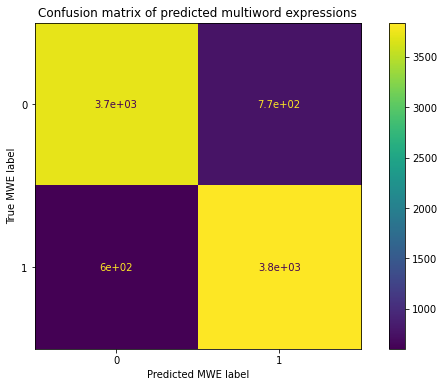

,words
0,Bacteriological water
1,water analysis
2,analytical procedure
3,human consumption
4,recreational waters
...,...
5950,Roy Soccer
5951,Soccer Dome
5952,Dolton Bowl
5953,bowling alley


In [6]:
j2=Journal2()

# import data
wiki=j2.importData()
wiki

# data preprocessing
print('Start data processing: ',datetime.now())
tarr=j2.combineRespectiveSentences(wiki)
text=j2.combineAllSentences(tarr)
actualMwe=j2.extractDatasetMWE(wiki)
word2pos=j2.generatePosTag(tarr)
potentialMwe=j2.listPotentialMWE(word2pos)
potentialMwe=j2.verifyIfMwe(potentialMwe,actualMwe)
potentialMwe=j2.countHitWords(potentialMwe,text)
potentialMwe=j2.statisticalAnalyzer(potentialMwe,text)
print('End data processing: ',datetime.now())
print(tarr)
print(text)
print(actualMwe)
print(word2pos)
print(potentialMwe)
xtrain,ytrain,xtest,ytest=j2.splitXYTrainTestWithSmote(potentialMwe)

# build, train and test data
rfClassifier=j2.randomForestClassifier(xtrain,ytrain)
fscore,cMatrix=j2.predictWithClassifier(rfClassifier,xtest,ytest)
# graph plot confusion matrix
j2.plotConfusionMatrix(rfClassifier,xtest,ytest)

# use model to predict mwe from total data
mwe,non_mwe=j2.writePredictionToCsv(potentialMwe,rfClassifier)
mwe